## Import Libraries

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

## Rading Data

In [2]:
class FeatureDataset(Dataset):
    def __init__(self, features_path):
        self.features = torch.load(features_path)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]

In [3]:
train_dataset = FeatureDataset('./entry_data/train_data.pt')
test_dataset = FeatureDataset('./entry_data/test_data.pt')
valid_dataset = FeatureDataset('./entry_data/valid_data.pt')

C:\Users\moah\AppData\Local\Temp\ipykernel_19128\4113187193.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.features = torch.load(features_path)


In [4]:
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
l=next(iter(valid_dataloader))

In [22]:
l.keys()

dict_keys(['image_features', 'label'])

## classification network

In [74]:
class IP102(nn.Module):
    def __init__(self, input_dim , num_classes):
        super(IP102, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512), 
            nn.ReLU(),
            nn.Dropout(0.5),     

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),    

            nn.Linear(256, num_classes)
        )

    def forward(self,x):
        return self.network(x)

In [75]:
INPUT_DIM = 1024 
NUM_CLASSES = 102 
NUM_EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training Faze

In [76]:
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: torch.device
):
    model.eval()  
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            features = batch['image_features'].to(device)
            labels = batch['label'].to(device)
            
            if features.dim() == 3 and features.shape[1] == 1:
                features = features.squeeze(1)

            outputs = model(features)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    
    return epoch_loss, epoch_acc

In [82]:
def train(
    model,
    train_dataloader,
    valid_dataloader,
    optimizer,
    criterion,
    epochs,
    device
):
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    model.to(device)
    for epoch in range(epochs):
        model.train() 
        train_running_loss = 0.0
        train_correct_predictions = 0
        train_total_samples = 0
        
        train_loader_tqdm = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
        
        noise_level = 0.3
        for batch in train_loader_tqdm:
            features = batch['image_features'].to(device)
            labels = batch['label'].to(device)
            
            if features.dim() == 3 and features.shape[1] == 1:
                features = features.squeeze(1)
            
            if model.training:
                features = features + (torch.randn_like(features) * noise_level)


            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_running_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total_samples += labels.size(0)
            train_correct_predictions += (predicted == labels).sum().item()
            train_loader_tqdm.set_postfix(loss=loss.item())

        epoch_train_loss = train_running_loss / train_total_samples
        epoch_train_acc = train_correct_predictions / train_total_samples
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        val_loss, val_acc = evaluate(model, valid_dataloader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )
    
    print("Training finished!")
    return history


In [89]:
criterion = nn.CrossEntropyLoss()
model = IP102(input_dim=INPUT_DIM, num_classes=NUM_CLASSES)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [90]:
history = train(
    model,
    train_dataloader,
    valid_dataloader,
    optimizer,
    criterion,
    30,
    device
    )

Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1453.20it/s]


Epoch 1/30 | Train Loss: 1.9434, Train Acc: 0.5031 | Val Loss: 1.3476, Val Acc: 0.6183


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1101.00it/s]


Epoch 2/30 | Train Loss: 1.4228, Train Acc: 0.5962 | Val Loss: 1.1961, Val Acc: 0.6520


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1247.49it/s]


Epoch 3/30 | Train Loss: 1.3099, Train Acc: 0.6227 | Val Loss: 1.1480, Val Acc: 0.6628


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1566.02it/s]


Epoch 4/30 | Train Loss: 1.2351, Train Acc: 0.6398 | Val Loss: 1.1028, Val Acc: 0.6801


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1326.93it/s]


Epoch 5/30 | Train Loss: 1.1791, Train Acc: 0.6526 | Val Loss: 1.0786, Val Acc: 0.6813


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1411.39it/s]


Epoch 6/30 | Train Loss: 1.1430, Train Acc: 0.6601 | Val Loss: 1.0578, Val Acc: 0.6902


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1367.17it/s]


Epoch 7/30 | Train Loss: 1.1098, Train Acc: 0.6694 | Val Loss: 1.0419, Val Acc: 0.6923


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1584.33it/s]


Epoch 8/30 | Train Loss: 1.0801, Train Acc: 0.6788 | Val Loss: 1.0253, Val Acc: 0.7002


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1575.44it/s]


Epoch 9/30 | Train Loss: 1.0511, Train Acc: 0.6838 | Val Loss: 1.0158, Val Acc: 0.6998


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1521.44it/s]


Epoch 10/30 | Train Loss: 1.0357, Train Acc: 0.6887 | Val Loss: 1.0042, Val Acc: 0.7022


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1501.68it/s]


Epoch 11/30 | Train Loss: 1.0040, Train Acc: 0.6971 | Val Loss: 0.9952, Val Acc: 0.7078


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1049.65it/s]


Epoch 12/30 | Train Loss: 0.9920, Train Acc: 0.6960 | Val Loss: 0.9993, Val Acc: 0.7036


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1257.55it/s]


Epoch 13/30 | Train Loss: 0.9696, Train Acc: 0.7031 | Val Loss: 0.9882, Val Acc: 0.7075


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1220.98it/s]


Epoch 14/30 | Train Loss: 0.9486, Train Acc: 0.7101 | Val Loss: 0.9829, Val Acc: 0.7103


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1445.25it/s]


Epoch 15/30 | Train Loss: 0.9380, Train Acc: 0.7115 | Val Loss: 0.9682, Val Acc: 0.7104


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1330.81it/s]


Epoch 16/30 | Train Loss: 0.9219, Train Acc: 0.7160 | Val Loss: 0.9610, Val Acc: 0.7167


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1282.68it/s]


Epoch 17/30 | Train Loss: 0.9151, Train Acc: 0.7173 | Val Loss: 0.9657, Val Acc: 0.7146


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1188.07it/s]


Epoch 18/30 | Train Loss: 0.8947, Train Acc: 0.7265 | Val Loss: 0.9582, Val Acc: 0.7184


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1609.98it/s]


Epoch 19/30 | Train Loss: 0.8807, Train Acc: 0.7261 | Val Loss: 0.9568, Val Acc: 0.7202


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1330.52it/s]


Epoch 20/30 | Train Loss: 0.8687, Train Acc: 0.7284 | Val Loss: 0.9587, Val Acc: 0.7219


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1220.06it/s]


Epoch 21/30 | Train Loss: 0.8587, Train Acc: 0.7297 | Val Loss: 0.9577, Val Acc: 0.7179


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1226.65it/s]


Epoch 22/30 | Train Loss: 0.8444, Train Acc: 0.7368 | Val Loss: 0.9495, Val Acc: 0.7219


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1466.21it/s]


Epoch 23/30 | Train Loss: 0.8376, Train Acc: 0.7355 | Val Loss: 0.9505, Val Acc: 0.7226


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1317.81it/s]


Epoch 24/30 | Train Loss: 0.8360, Train Acc: 0.7397 | Val Loss: 0.9548, Val Acc: 0.7215


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1267.03it/s]


Epoch 25/30 | Train Loss: 0.8206, Train Acc: 0.7437 | Val Loss: 0.9413, Val Acc: 0.7226


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1212.09it/s]


Epoch 26/30 | Train Loss: 0.8118, Train Acc: 0.7443 | Val Loss: 0.9497, Val Acc: 0.7255


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1404.13it/s]


Epoch 27/30 | Train Loss: 0.7990, Train Acc: 0.7469 | Val Loss: 0.9417, Val Acc: 0.7271


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1300.77it/s]


Epoch 28/30 | Train Loss: 0.8012, Train Acc: 0.7451 | Val Loss: 0.9416, Val Acc: 0.7266


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1292.27it/s]


Epoch 29/30 | Train Loss: 0.7923, Train Acc: 0.7483 | Val Loss: 0.9394, Val Acc: 0.7262


Evaluating: 100%|██████████| 118/118 [00:00<00:00, 1215.01it/s]

Epoch 30/30 | Train Loss: 0.7849, Train Acc: 0.7516 | Val Loss: 0.9419, Val Acc: 0.7264
Training finished!


## evaluatation

In [91]:
evaluate(
    model,
    test_dataloader,
    criterion,
    device
)

Evaluating: 100%|██████████| 354/354 [00:00<00:00, 672.25it/s]


(0.9558765508731557, 0.7215615190768823)

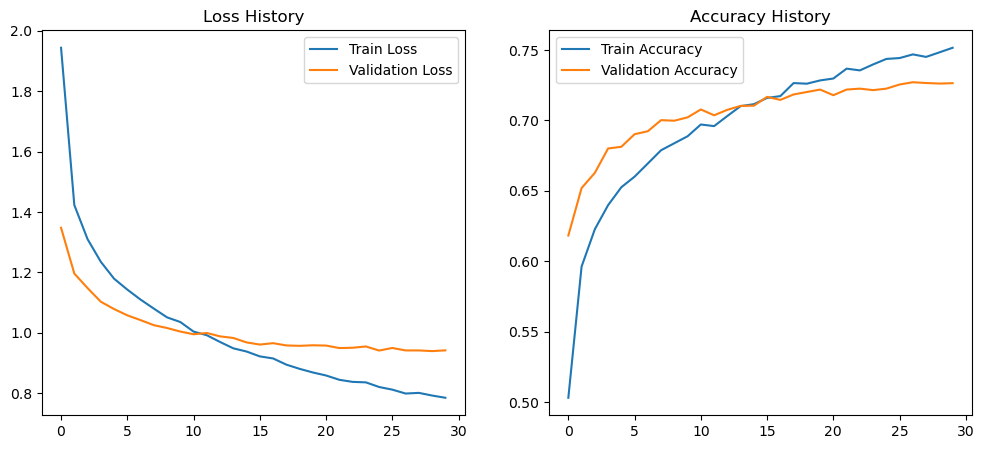

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss History')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy History')
plt.legend()
plt.show()